In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pandas as pd
import os
import csv
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
from datetime import datetime
from collections import deque
from torch.utils.data import Dataset, DataLoader
from torch.distributions import Normal

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



In [ ]:

# --------------------------
# Data Handling
# --------------------------
class DiabetesDataset(Dataset):
    """Processed diabetes management dataset."""
    
    def __init__(self, csv_file):
        # Load data and fill missing values
        df = pd.read_csv(csv_file)
        df = df.ffill().bfill()
        
        # Ensure key features have no missing values
        if df[["glu", "glu_d", "glu_t", "hr", "hr_d", "hr_t", "iob", "hour"]].isna().any().any():
            raise ValueError("Dataset contains NaN values after preprocessing")
        
        # Verify that action values are within [-1, 1]
        assert df["action"].between(-1, 1).all(), "Actions must be between -1 and 1"
        
        # Prepare state features and action values
        self.states = df[["glu", "glu_d", "glu_t", "hr", "hr_d", "hr_t", "iob", "hour"]].values.astype(np.float32)
        self.actions = df["action"].values.astype(np.float32).reshape(-1, 1)
        
        # Compute rewards from the glu_raw values
        self.rewards = self._compute_rewards(df["glu_raw"].values)
        
        # Create transitions: next_states via roll and done flags
        self.next_states = np.roll(self.states, -1, axis=0)
        self.dones = df["done"].values.astype(np.float32)
        
        # Remove last transition (invalid next state)
        self._sanitize_transitions()
    
    def _compute_rewards(self, glucose_next):
        """
        Compute rewards using a rescaled Risk Index (RI)-based function.
        Based on Kovatchev et al. (2005), extended with a severe hypoglycemia penalty.
        """
        glucose = np.clip(glucose_next.astype(np.float32), 10, 400)  # Clamp extreme values

        # Step 1: Risk transformation function
        log_glucose = np.log(glucose)
        f = 1.509 * (np.power(log_glucose, 1.084) - 5.381)
        r = 10 * np.square(f)

        # Step 2: LBGI and HBGI
        lbgi = np.where(f < 0, r, 0)
        hbgi = np.where(f > 0, r, 0)

        # Step 3: Total Risk Index (RI)
        ri = lbgi + hbgi

        # Step 4: Rescale RI and convert to reward
        normalized_ri = -ri / 10.0  # Stronger signal than /100
        rewards = np.clip(normalized_ri, -5.0, 0.0)

        # Step 5: Severe hypoglycemia penalty
        severe_hypo_penalty = np.where(glucose <= 39, -15.0, 0.0)
        rewards += severe_hypo_penalty

        # Step 6: Optional time penalty
        rewards -= 0.01  # Encourage faster correction

        return np.clip(rewards, -15.0, 0.0).astype(np.float32)


    
    def _sanitize_transitions(self):
        """Remove the last transition which lacks a valid next state."""
        valid_mask = np.ones(len(self.states), dtype=bool)
        valid_mask[-1] = False
        self.states = self.states[valid_mask]
        self.actions = self.actions[valid_mask]
        self.rewards = self.rewards[valid_mask]
        self.next_states = self.next_states[valid_mask]
        self.dones = self.dones[valid_mask]
    
    def __len__(self):
        return len(self.states)
    
    def __getitem__(self, idx):
        return {
            'state': torch.FloatTensor(self.states[idx]),
            'action': torch.FloatTensor(self.actions[idx]),
            'reward': torch.FloatTensor([self.rewards[idx]]),
            'next_state': torch.FloatTensor(self.next_states[idx]),
            'done': torch.FloatTensor([self.dones[idx]])
        }



In [18]:


# --------------------------
# Actor: Gaussian Policy Network
# --------------------------
class GaussianActor(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_units=32):
        super().__init__()
        # Three dense layers with 32 units each
        self.fc1 = nn.Linear(state_dim, hidden_units)
        self.fc2 = nn.Linear(hidden_units, hidden_units)
        self.fc3 = nn.Linear(hidden_units, hidden_units)
        # Separate output heads for mean and log_std
        self.mean_head = nn.Linear(hidden_units, action_dim)
        self.log_std_head = nn.Linear(hidden_units, action_dim)
        self.LOG_STD_MIN = -20
        self.LOG_STD_MAX = 2
        
        # Initialize weights
        for layer in [self.fc1, self.fc2, self.fc3, self.mean_head, self.log_std_head]:
            nn.init.xavier_uniform_(layer.weight)
            nn.init.zeros_(layer.bias)
            
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        mean = self.mean_head(x)
        log_std = self.log_std_head(x)
        log_std = torch.clamp(log_std, self.LOG_STD_MIN, self.LOG_STD_MAX)
        std = torch.exp(log_std)
        return mean, std
    
    def sample(self, state):
        mean, std = self.forward(state)
        dist = Normal(mean, std)
        x_t = dist.rsample()  # Reparameterization trick
        action = torch.tanh(x_t)  # Squash to [-1, 1]
        # Compute log probability with tanh correction
        log_prob = dist.log_prob(x_t)
        log_prob = log_prob.sum(dim=-1, keepdim=True)
        log_prob -= torch.log(1 - action.pow(2) + 1e-6).sum(dim=-1, keepdim=True)
        return action, log_prob

# --------------------------
# Critic: Q-Network
# --------------------------
class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_units=32):
        super().__init__()
        self.fc1 = nn.Linear(state_dim + action_dim, hidden_units)
        self.fc2 = nn.Linear(hidden_units, hidden_units)
        self.fc3 = nn.Linear(hidden_units, hidden_units)
        self.out = nn.Linear(hidden_units, 1)
        
        for layer in [self.fc1, self.fc2, self.fc3, self.out]:
            nn.init.xavier_uniform_(layer.weight)
            nn.init.zeros_(layer.bias)
            
    def forward(self, state, action):
        x = torch.cat([state, action], dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        q = self.out(x)
        return q



In [19]:

# --------------------------
# SAC Agent
# --------------------------
class SACAgent(nn.Module):
    """SAC agent with a Gaussian policy and twin Q-networks."""
    def __init__(self, state_dim=8, action_dim=1,
                 actor_lr=3e-4, critic_lr=3e-4, alpha_lr=3e-4,
                 target_entropy=-1, gamma=0.997, tau=0.005):
        super().__init__()
        self.gamma = gamma
        self.tau = tau
        self.target_entropy = target_entropy
        
        # Actor (policy) network
        self.actor = GaussianActor(state_dim, action_dim).to(device)
        
        # Twin Q-networks
        self.q1 = QNetwork(state_dim, action_dim).to(device)
        self.q2 = QNetwork(state_dim, action_dim).to(device)
        # Target networks
        self.q1_target = QNetwork(state_dim, action_dim).to(device)
        self.q2_target = QNetwork(state_dim, action_dim).to(device)
        self.q1_target.load_state_dict(self.q1.state_dict())
        self.q2_target.load_state_dict(self.q2.state_dict())
        
        # Entropy temperature (initialized to 0.1) as log_alpha for numerical stability
        self.log_alpha = torch.tensor([0.1], requires_grad=True, device=device)
        
        # Optimizers for actor, critic, and temperature
        self.actor_optim = optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optim = optim.Adam(list(self.q1.parameters()) + list(self.q2.parameters()), lr=critic_lr)
        self.alpha_optim = optim.Adam([self.log_alpha], lr=alpha_lr)
        
    def act(self, state):
        """Deterministic action for evaluation: use the mean and apply tanh."""
        mean, _ = self.actor.forward(state)
        return torch.tanh(mean)
    
    def update_targets(self):
        """Soft-update target networks."""
        with torch.no_grad():
            for target_param, param in zip(self.q1_target.parameters(), self.q1.parameters()):
                target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)
            for target_param, param in zip(self.q2_target.parameters(), self.q2.parameters()):
                target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)



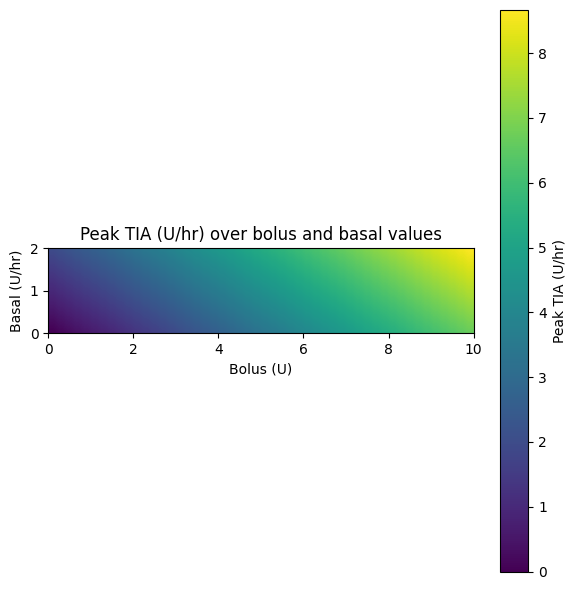

In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def compute_tia(df, DOA_hours=3, interval_min=5):
    """
    Compute the Total Insulin Action (TIA) for each row of the DataFrame.
    
    Parameters:
        df (pd.DataFrame): DataFrame with columns 'real_basal' (in U/hr) and 'bolus' (in U).
        DOA_hours (float): Duration of insulin action in hours (how long a bolus affects TIA).
        interval_min (float): Time difference between consecutive rows in minutes.
    
    Returns:
        pd.DataFrame: A new DataFrame with added 'TIA' column (U/hr).
    """
    # Convert time step to hours
    interval_hr = interval_min / 60.0
    
    # Number of steps for insulin decay
    decay_steps = int(DOA_hours / interval_hr)
    
    # Define decay curve (quadratic) and normalize to sum=1
    t = np.linspace(0, 1, decay_steps)
    decay = 1 - (t**2) * (3 - 2*t)  # Quadratic decay from 1 to 0
    decay /= decay.sum()  # Normalize so total decayed bolus = original amount
    
    # Compute bolus contributions over time using convolution
    bolus_contrib = np.convolve(df['bolus'], decay, mode='full')[:len(df)]
    
    # Convert bolus contribution to U/hr (since interval is in minutes)
    bolus_contrib_hr = bolus_contrib / (interval_min / 60)
    
    # Total Insulin Action = Basal (U/hr) + Bolus Contribution (U/hr)
    df_out = df.copy()
    df_out['TIA'] = df['real_basal'] + bolus_contrib_hr
    
    return df_out

# Parameters for simulation
DOA_hours = 3
interval_min = 5
n_steps = int(DOA_hours / (interval_min/60))

# Define ranges for bolus and basal
bolus_values = np.linspace(0, 10, 50)   # bolus in U
basal_values = np.linspace(0, 2, 50)      # basal in U/hr

# Prepare an array to store the peak TIA for each combination
TIA_peak = np.zeros((len(basal_values), len(bolus_values)))

# Loop over the grid and compute TIA peak
for i, basal in enumerate(basal_values):
    for j, bolus in enumerate(bolus_values):
        # Create a DataFrame: simulate a single bolus at t=0 and then zeros
        df = pd.DataFrame({
            'real_basal': np.full(n_steps, basal),
            'bolus': np.zeros(n_steps)
        })
        # Inject the bolus at the first time step
        df.loc[0, 'bolus'] = bolus
        
        # Compute TIA
        df_tia = compute_tia(df, DOA_hours=DOA_hours, interval_min=interval_min)
        # The peak TIA (should be at the start) is:
        peak = df_tia['TIA'].max()
        TIA_peak[i, j] = peak

# Plot the heatmap
plt.figure(figsize=(6,6))
# Use extent to properly label axes: x for bolus, y for basal.
plt.imshow(TIA_peak, origin='lower', aspect='equal',
           extent=[bolus_values[0], bolus_values[-1], basal_values[0], basal_values[-1]])
plt.xlabel('Bolus (U)')
plt.ylabel('Basal (U/hr)')
plt.title('Peak TIA (U/hr) over bolus and basal values')
plt.colorbar(label='Peak TIA (U/hr)')
plt.tight_layout()
plt.show()

In [ ]:
def train_sac3(dataset_path, epochs=100, batch_size=256, use_cql=False, cql_alpha=1.0):
    
    dataset = DiabetesDataset(dataset_path)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    agent = SACAgent().to(device)

    # Initialize epoch-level lists to collect rewards and actions for diagnostics
    for epoch in range(epochs):
        epoch_critic_loss = 0.0
        epoch_actor_loss = 0.0
        epoch_alpha_loss = 0.0
        epoch_reward = 0.0
        epoch_q_val = 0.0
        epoch_entropy = 0.0
        epoch_cql_penalty = 0.0
        num_batches = 0
        batch_count = 0  # To control target updates

        # Lists to collect all rewards and actions from this epoch for diagnostic stats.
        epoch_rewards_list = []
        epoch_actions_list = []

        for batch in dataloader:
            num_batches += 1
            batch_count += 1
            
            states      = batch['state'].to(device)
            actions     = batch['action'].to(device)
            rewards     = batch['reward'].to(device)
            next_states = batch['next_state'].to(device)
            dones       = batch['done'].to(device)

            # ---------- Critic Update ----------
            with torch.no_grad():
                next_actions, next_log_probs = agent.actor.sample(next_states)
                q1_next = agent.q1_target(next_states, next_actions)
                q2_next = agent.q2_target(next_states, next_actions)
                min_q_next = torch.min(q1_next, q2_next) - torch.exp(agent.log_alpha) * next_log_probs
                target_q = rewards + agent.gamma * (1 - dones) * min_q_next
                # Clip the target Q-value to prevent divergence.(IMPORTANT)
                target_q = torch.clamp(target_q, min=-10.0, max=5.0)

            current_q1 = agent.q1(states, actions)
            current_q2 = agent.q2(states, actions)
            critic_loss = F.mse_loss(current_q1, target_q) + F.mse_loss(current_q2, target_q)
            
            if use_cql:
                # Generate random actions
                random_actions = torch.empty_like(actions).uniform_(-1.0, 1.0)

                # Get policy actions from the actor
                policy_output = agent.actor(states)
                # If the actor returns a tuple (action, log_prob), extract the action:
                if isinstance(policy_output, tuple):
                    policy_actions = policy_output[0]
                else:
                    policy_actions = policy_output

                # Now compute Q-values using the extracted policy actions
                q1_policy = agent.q1(states, policy_actions)
                q2_policy = agent.q2(states, policy_actions)

                # Get Q-values from both critics for different action sets
                q1_rand = agent.q1(states, random_actions)
                q2_rand = agent.q2(states, random_actions)
                q1_policy = agent.q1(states, policy_actions)
                q2_policy = agent.q2(states, policy_actions)
                # current_q1 and current_q2 are the Q-values for the batch actions (data)
                q1_data = current_q1  
                q2_data = current_q2

                # Concatenate Q-values for log-sum-exp computation
                q1_cat = torch.cat([q1_rand, q1_policy, q1_data], dim=0)
                q2_cat = torch.cat([q2_rand, q2_policy, q2_data], dim=0)

                # Compute log-sum-exp for both critics
                q1_lse = torch.logsumexp(q1_cat, dim=0)
                q2_lse = torch.logsumexp(q2_cat, dim=0)

                # Compute the penalty as the difference between the log-sum-exp and the data Q-values
                cql_penalty = ((q1_lse.mean() - q1_data.mean()) +
                            (q2_lse.mean() - q2_data.mean()))

                # Add the penalty to the critic loss
                critic_loss += cql_alpha * cql_penalty

            agent.critic_optim.zero_grad()
            critic_loss.backward()
            agent.critic_optim.step()

            # ---------- Actor Update ----------
            new_actions, log_probs = agent.actor.sample(states)
            q1_val = agent.q1(states, new_actions)
            q2_val = agent.q2(states, new_actions)
            min_q_val = torch.min(q1_val, q2_val)
            actor_loss = (torch.exp(agent.log_alpha) * log_probs - min_q_val).mean()
            # L2 regularization on actor parameters
            l2_reg = 1e-4 * sum(torch.sum(p ** 2) for p in agent.actor.parameters())
            actor_loss += l2_reg

            agent.actor_optim.zero_grad()
            actor_loss.backward()
            agent.actor_optim.step()

            # ---------- Temperature (Alpha) Update ----------
            alpha_loss = -(agent.log_alpha * (log_probs + agent.target_entropy).detach()).mean()
            agent.alpha_optim.zero_grad()
            alpha_loss.backward()
            agent.alpha_optim.step()
            # Clamp log_alpha to prevent alpha (exp) from dropping too low
            with torch.no_grad():
               agent.log_alpha.data.clamp_(min=np.log(0.1), max=np.log(2.0))

            # Accumulate metrics for logging
            epoch_critic_loss += critic_loss.item()
            epoch_actor_loss  += actor_loss.item()
            epoch_alpha_loss  += alpha_loss.item()
            epoch_q_val       += min_q_val.mean().item()
            epoch_entropy     += (-log_probs).mean().item()
            epoch_cql_penalty += cql_penalty.item()

            # ---------- Diagnostic: Action Statistics ----------
            with torch.no_grad():
                # Sample actions from the current state batch for diagnostics
                sampled_actions, _ = agent.actor.sample(states)
                # Append to list for later aggregation
                epoch_actions_list.append(sampled_actions.detach().cpu())


            agent.update_targets()
        
        # After epoch, concatenate diagnostic lists and compute statistics.
        
        all_actions = torch.cat(epoch_actions_list, dim=0)
        actions_mean = all_actions.mean().item()
        actions_std = all_actions.std().item()
        actions_std = all_actions.std().item()
        
        
        # Print averaged metrics for the epoch with additional diagnostics.
        with torch.no_grad():
            alpha_value = torch.exp(agent.log_alpha).item()
        print(f"Epoch {epoch+1}/{epochs}: "
            f"Critic Loss: {epoch_critic_loss/num_batches:.4f}, "
            f"Actor Loss: {epoch_actor_loss/num_batches:.4f}, "
            f"Alpha Loss: {epoch_alpha_loss/num_batches:.4f}, "
            f"Alpha (exp): {alpha_value:.4f}, "
            f"CQL: {epoch_cql_penalty/num_batches:.4f}, "
            f"Avg Q: {epoch_q_val/num_batches:.4f}, "
            f"Avg Entropy: {epoch_entropy/num_batches:.4f}, "
            f"Actions (mean,std): ({actions_mean:.4f},{actions_std:.4f})")
        
    return agent


In [120]:
agent_new = train_sac3(dataset_path="datasets/processed/563-training.csv",use_cql=True,cql_alpha=0.1)
torch.save(agent_new.state_dict(), "sac_new.pth")

Epoch 1/100: Critic Loss: 1.9681, Actor Loss: -0.5341, Alpha Loss: 0.1520, Alpha (exp): 1.0880, CQL: 13.3777, Avg Q: -0.1677, Avg Entropy: 0.6473, Actions (mean,std): (0.0042,0.6020)
Epoch 2/100: Critic Loss: 1.6632, Actor Loss: -0.7164, Alpha Loss: 0.1280, Alpha (exp): 1.0710, CQL: 13.4378, Avg Q: -0.0002, Avg Entropy: 0.6711, Actions (mean,std): (0.0249,0.5934)
Epoch 3/100: Critic Loss: 1.5850, Actor Loss: -0.8163, Alpha Loss: 0.1022, Alpha (exp): 1.0543, CQL: 13.4828, Avg Q: 0.1029, Avg Entropy: 0.6788, Actions (mean,std): (0.0036,0.5937)
Epoch 4/100: Critic Loss: 1.5483, Actor Loss: -0.8814, Alpha Loss: 0.0757, Alpha (exp): 1.0379, CQL: 13.5060, Avg Q: 0.1807, Avg Entropy: 0.6773, Actions (mean,std): (0.0027,0.5932)
Epoch 5/100: Critic Loss: 1.5276, Actor Loss: -0.9306, Alpha Loss: 0.0495, Alpha (exp): 1.0217, CQL: 13.5333, Avg Q: 0.2384, Avg Entropy: 0.6797, Actions (mean,std): (-0.0101,0.5912)
Epoch 6/100: Critic Loss: 1.5196, Actor Loss: -0.9720, Alpha Loss: 0.0232, Alpha (exp):

In [53]:
agent_safe = train_sac3(dataset_path="datasets/processed/full-training.csv",use_cql=True,cql_alpha=0.01)
final_model_path = "sacsafe.pth"
torch.save(agent.state_dict(), final_model_path)

Epoch 1/100: Critic Loss: 0.3980, Actor Loss: -0.8650, Alpha Loss: 0.0914, Alpha (exp): 1.0095, CQL: 1.3841, Avg Q: 0.1659, Avg Entropy: 0.6695, Actions (mean,std): (0.0046,0.5930)
Epoch 2/100: Critic Loss: 0.2105, Actor Loss: -0.8509, Alpha Loss: -0.0597, Alpha (exp): 0.9223, CQL: 1.3912, Avg Q: 0.2026, Avg Entropy: 0.6798, Actions (mean,std): (0.0006,0.5884)
Epoch 3/100: Critic Loss: 0.1682, Actor Loss: -0.7860, Alpha Loss: -0.2113, Alpha (exp): 0.8428, CQL: 1.3987, Avg Q: 0.1942, Avg Entropy: 0.6797, Actions (mean,std): (0.0039,0.5822)
Epoch 4/100: Critic Loss: 0.1506, Actor Loss: -0.7194, Alpha Loss: -0.3629, Alpha (exp): 0.7702, CQL: 1.4019, Avg Q: 0.1781, Avg Entropy: 0.6809, Actions (mean,std): (0.0108,0.5841)
Epoch 5/100: Critic Loss: 0.1425, Actor Loss: -0.6497, Alpha Loss: -0.5141, Alpha (exp): 0.7038, CQL: 1.4038, Avg Q: 0.1561, Avg Entropy: 0.6800, Actions (mean,std): (0.0119,0.5824)
Epoch 6/100: Critic Loss: 0.1404, Actor Loss: -0.5772, Alpha Loss: -0.6654, Alpha (exp): 0.

In [ ]:
agent = train_sac3(dataset_path="datasets/processed/full-training.csv")
final_model_path = "sac3.pth"
torch.save(agent.state_dict(), final_model_path)

Epoch 1/100: Critic Loss: 0.4852, Actor Loss: -0.7642, Alpha Loss: 0.0875, Alpha (exp): 1.0076, Avg Reward: -0.4459 [min: -2.8623, max: -0.0100, std: 0.4975], Avg Q: 0.0906, Avg Entropy: 0.6466, Actions (mean,std): (-0.0249,0.5898)
Epoch 2/100: Critic Loss: 0.2128, Actor Loss: -0.7919, Alpha Loss: -0.0634, Alpha (exp): 0.9200, Avg Reward: -0.4456 [min: -2.8623, max: -0.0100, std: 0.4975], Avg Q: 0.1478, Avg Entropy: 0.6767, Actions (mean,std): (-0.0008,0.5889)
Epoch 3/100: Critic Loss: 0.1626, Actor Loss: -0.7537, Alpha Loss: -0.2153, Alpha (exp): 0.8405, Avg Reward: -0.4454 [min: -2.8623, max: -0.0100, std: 0.4975], Avg Q: 0.1660, Avg Entropy: 0.6765, Actions (mean,std): (0.0150,0.5861)
Epoch 4/100: Critic Loss: 0.1449, Actor Loss: -0.7061, Alpha Loss: -0.3667, Alpha (exp): 0.7680, Avg Reward: -0.4456 [min: -2.8623, max: -0.0100, std: 0.4975], Avg Q: 0.1697, Avg Entropy: 0.6765, Actions (mean,std): (0.0314,0.5862)
Epoch 5/100: Critic Loss: 0.1330, Actor Loss: -0.6460, Alpha Loss: -0.5

In [47]:
agent_cql = train_sac3(dataset_path="datasets/processed/full-training.csv",use_cql=True,cql_alpha=0.01)
final_model_path = "sac_cql.pth"
torch.save(agent.state_dict(), final_model_path)

Epoch 1/100: Critic Loss: 0.5377, Actor Loss: -0.7944, Alpha Loss: 0.0890, Alpha (exp): 1.0082, Avg Reward: -0.4457 [min: -2.8623, max: -0.0100, std: 0.4975], Avg Q: 0.1090, Avg Entropy: 0.6571, Actions (mean,std): (0.0029,0.6072)
Epoch 2/100: Critic Loss: 0.2161, Actor Loss: -0.7884, Alpha Loss: -0.0621, Alpha (exp): 0.9209, Avg Reward: -0.4455 [min: -2.8623, max: -0.0100, std: 0.4975], Avg Q: 0.1414, Avg Entropy: 0.6789, Actions (mean,std): (-0.0048,0.5886)
Epoch 3/100: Critic Loss: 0.1611, Actor Loss: -0.7227, Alpha Loss: -0.2143, Alpha (exp): 0.8413, Avg Reward: -0.4455 [min: -2.8623, max: -0.0100, std: 0.4975], Avg Q: 0.1307, Avg Entropy: 0.6805, Actions (mean,std): (-0.0081,0.5848)
Epoch 4/100: Critic Loss: 0.1391, Actor Loss: -0.6587, Alpha Loss: -0.3660, Alpha (exp): 0.7687, Avg Reward: -0.4455 [min: -2.8623, max: -0.0100, std: 0.4975], Avg Q: 0.1183, Avg Entropy: 0.6805, Actions (mean,std): (-0.0101,0.5852)
Epoch 5/100: Critic Loss: 0.1290, Actor Loss: -0.5886, Alpha Loss: -0.

In [101]:
def evaluate_sac_policy(model_pth_path, test_csv_path, device='cpu', batch_size=256):

   # 1. Initialize a fresh agent instance and load the weights
    agent = SACAgent().to(device)
    agent.load_state_dict(torch.load(model_pth_path, map_location=device))
    agent.eval()  # set to evaluation mode

    # 2. Load the test dataset (assuming DiabetesDataset is defined/imported)
    test_dataset = DiabetesDataset(test_csv_path)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Accumulators for Q-values, predicted actions, actual actions, etc.
    total_q = 0.0
    total_count = 0
    predicted_actions_all = []
    actual_actions_all = []

    with torch.no_grad():
        for batch in test_loader:
            states = batch["state"].to(device)
            actual_actions = batch["action"].to(device)
            
            # Sample an action from the policy for the given states.
            #predicted_actions, _ = agent.actor.sample(states)
            predicted_actions = agent.act(states)
            
            # Compute Q-values for the predicted actions.
            q1_vals = agent.q1(states, predicted_actions)
            q2_vals = agent.q2(states, predicted_actions)
            min_q_vals = torch.min(q1_vals, q2_vals)
            
            total_q += min_q_vals.sum().item()
            total_count += states.size(0)
            
            # Accumulate predicted and actual actions
            predicted_actions_all.append(predicted_actions.cpu().numpy())
            actual_actions_all.append(actual_actions.cpu().numpy())
    
    avg_q = total_q / total_count if total_count > 0 else 0.0

    # Concatenate the lists of actions
    predicted_actions_all = np.concatenate(predicted_actions_all, axis=0) if predicted_actions_all else np.array([])
    actual_actions_all = np.concatenate(actual_actions_all, axis=0) if actual_actions_all else np.array([])
    
    # Compute statistics for predicted actions
    pred_action_mean = float(predicted_actions_all.mean()) if predicted_actions_all.size > 0 else 0.0
    pred_action_std  = float(predicted_actions_all.std()) if predicted_actions_all.size > 0 else 0.0
    
    # Compute statistics for actual actions
    actual_action_mean = float(actual_actions_all.mean()) if actual_actions_all.size > 0 else 0.0
    actual_action_std  = float(actual_actions_all.std()) if actual_actions_all.size > 0 else 0.0
    
    # Compute the Mean Squared Error (MSE) between predicted and actual actions
    mse = np.mean((predicted_actions_all - actual_actions_all)**2) if predicted_actions_all.size > 0 else 0.0

    # Print out the evaluation metrics
    print("Offline Evaluation (test set):")
    print(f"  Average Q(s, pi(s)): {avg_q:.4f}")
    print(f"  Predicted Actions -> mean: {pred_action_mean:.4f}, std: {pred_action_std:.4f}")
    print(f"  Actual Actions    -> mean: {actual_action_mean:.4f}, std: {actual_action_std:.4f}")
    print(f"  Mean Squared Error between predicted and actual actions: {mse:.4f}")

    
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.hist(predicted_actions_all, bins=50, alpha=0.6, label='Predicted Actions')
    plt.hist(actual_actions_all, bins=50, alpha=0.6, label='Actual Actions')
    plt.title("Action Distributions")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.scatter(actual_actions_all, predicted_actions_all, alpha=0.3)
    plt.plot([-1, 1], [-1, 1], 'r--')
    plt.xlabel("Actual Action")
    plt.ylabel("Predicted Action")
    plt.title("Actual vs. Predicted Actions")

    plt.tight_layout()
    plt.show()

    return 


Offline Evaluation (test set):
  Average Q(s, pi(s)): -5.3316
  Predicted Actions -> mean: -0.3346, std: 0.2097
  Actual Actions    -> mean: -0.3082, std: 0.2077
  Mean Squared Error between predicted and actual actions: 0.0309


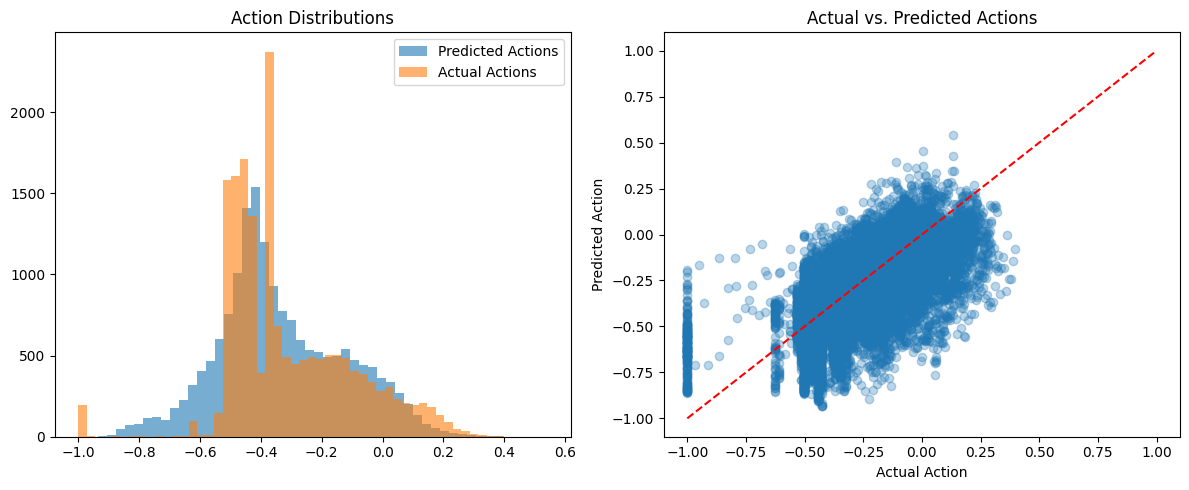

In [121]:
evaluate_sac_policy("sac_new.pth", "datasets/processed/full-testing.csv", device='cpu', batch_size=256)